### 0. Directory setting

In [1]:
import os
import sys

# Get current notebook directory
notebook_dir = os.getcwd()

# Navigate to project root if notebook is in 'notebooks' folder
project_dir = notebook_dir
if os.path.basename(notebook_dir) == 'notebooks':
    project_dir = os.path.dirname(notebook_dir)
    os.chdir(project_dir)

# Add project root to sys.path if not already included
if project_dir not in sys.path:
    sys.path.insert(0, project_dir)

### 1. Imports and Setup

In [2]:

# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import logging
import os

# Import custom modules
import sys
sys.path.append('./')
from utils.data_loader import load_data, normalize_data, create_sequences
from utils.model_utils import LSTMAutoencoder, GRUAutoencoder, TransformerEncoder, train_model
from utils.model_utils import get_reconstruction_errors, EnsembleModel
from utils.evaluation import evaluate_threshold, AnomalyInterpreter, visualize_results
from utils.evaluation import plot_roc_curves, plot_precision_recall_curves

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

np.random.seed(42)
torch.manual_seed(42)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
logger.info(f"Usando dispositivo: {device}")



2025-05-23 21:39:42,377 - INFO - Usando dispositivo: cpu


### 2. Pre-trained Model Loading

In [3]:

# Load pre-trained models
def load_pretrained_models(base_path="models/autoencoder/"):
    """Load pre-trained autoencoder models."""
    # Load model metadata
    import json
    
    try:
        with open(os.path.join(base_path, "model_metadata.json"), "r") as f:
            metadata = json.load(f)
    except FileNotFoundError:
        logger.warning("Archivo de metadatos no encontrado, usando valores por defecto.")
        metadata = {"sequence_length": 150, "embedding_dim": 64}
    
    seq_len = metadata.get("sequence_length", 150)
    embedding_dim = metadata.get("embedding_dim", 64)
    
    # Initialize models - IMPORTANTE: usar d_model=48 para el Transformer
    lstm_model = LSTMAutoencoder(seq_len=seq_len, n_features=1, embedding_dim=embedding_dim)
    gru_model = GRUAutoencoder(seq_len=seq_len, n_features=1, embedding_dim=embedding_dim)
    transformer_model = TransformerEncoder(seq_len=seq_len, n_features=1, d_model=48, nhead=4)
    
    # Load weights
    try:
        lstm_model.load_state_dict(torch.load(os.path.join(base_path, "lstm_model.pt")))
        gru_model.load_state_dict(torch.load(os.path.join(base_path, "gru_model.pt")))
        transformer_model.load_state_dict(torch.load(os.path.join(base_path, "transformer_model.pt")))
        logger.info(f"Modelos cargados correctamente desde {base_path}")
    except Exception as e:
        logger.error(f"Error al cargar modelos: {e}")
    
    return {
        "lstm": lstm_model,
        "gru": gru_model,
        "transformer": transformer_model
    }, metadata


### 3. New Dataset Loading and Preprocessing

In [4]:

# Load new dataset
def load_new_dataset(filepath, sequence_length=150, step=10, train_ratio=0.7, val_ratio=0.15):
    """Load and prepare a new dataset for transfer learning."""
    df = load_data(filepath)
    data_scaled, scaler = normalize_data(df[['value']])
    
    X = create_sequences(data_scaled, seq_length=sequence_length, step=step)
    
    # Split data without labels
    train_size = int(len(X) * train_ratio)
    val_size = int(len(X) * val_ratio)
    
    X_train = X[:train_size]
    X_val = X[train_size:train_size+val_size]
    X_test = X[train_size+val_size:]
    
    # Create dataloaders
    batch_size = 64
    X_train_tensor = torch.FloatTensor(X_train)
    X_val_tensor = torch.FloatTensor(X_val)
    X_test_tensor = torch.FloatTensor(X_test)
    
    train_dataset = TensorDataset(X_train_tensor)
    val_dataset = TensorDataset(X_val_tensor)
    test_dataset = TensorDataset(X_test_tensor)
    
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    return {
        "dataframe": df,
        "scaler": scaler,
        "sequences": {
            "X_train": X_train,
            "X_val": X_val,
            "X_test": X_test
        },
        "loaders": {
            "train": train_loader,
            "val": val_loader,
            "test": test_loader
        }
    }


### 4. Transfer Learning Application

In [5]:

# Apply transfer learning
def apply_transfer_learning(pretrained_model, new_data_loaders, freeze_encoder=True, n_epochs=20, learning_rate=1e-4):
    """Apply transfer learning to a pre-trained model on new data."""
    model = pretrained_model.to(device)
    
    # Freeze encoder layers if specified
    if freeze_encoder:
        for name, param in model.named_parameters():
            if 'encoder' in name:
                param.requires_grad = False
    
    # Fine-tune on new data
    history, fine_tuned_model = train_model(
        model, new_data_loaders["train"], new_data_loaders["val"],
        n_epochs=n_epochs, learning_rate=learning_rate,
        device=device, patience=5, min_delta=0.0001
    )
    
    return history, fine_tuned_model

# Load a new dataset
new_filepath = 'data/ambient_temperature_system_failure.csv'  # Replace with your new dataset
new_data = load_new_dataset(new_filepath)

# Load pre-trained models
pretrained_models, metadata = load_pretrained_models()

# Apply transfer learning to LSTM model
lstm_history, fine_tuned_lstm = apply_transfer_learning(
    pretrained_models["lstm"], new_data["loaders"],
    freeze_encoder=True, n_epochs=20
)

# Apply transfer learning to GRU model
gru_history, fine_tuned_gru = apply_transfer_learning(
    pretrained_models["gru"], new_data["loaders"],
    freeze_encoder=True, n_epochs=20
)

# Apply transfer learning to Transformer model
transformer_history, fine_tuned_transformer = apply_transfer_learning(
    pretrained_models["transformer"], new_data["loaders"],
    freeze_encoder=True, n_epochs=20
)


2025-05-23 21:39:42,417 - INFO - Charging data from data/ambient_temperature_system_failure.csv
2025-05-23 21:39:42,437 - INFO - Charged data: 7267 registers
2025-05-23 21:39:42,464 - INFO - Modelos cargados correctamente desde models/autoencoder/
2025-05-23 21:39:42,466 - INFO - Starting model training LSTMAutoencoder
C:\Users\aleja\AppData\Roaming\Python\Python313\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
2025-05-23 21:39:45,528 - INFO - Epoch 1/20, Train Loss: 0.08086, Val Loss: 0.18177
2025-05-23 21:39:46,764 - INFO - Epoch 2/20, Train Loss: 0.07959, Val Loss: 0.17944
2025-05-23 21:39:47,998 - INFO - Epoch 3/20, Train Loss: 0.07817, Val Loss: 0.17713
2025-05-23 21:39:49,161 - INFO - Epoch 4/20, Train Loss: 0.07659, Val Loss: 0.17485
2025-05-23 21:39:50,410 - INFO - Epoch 5/20, Train Loss: 0.07617, Val Loss: 0.17260
2025-05-23 21:39:51,573 - INFO - Epoch 6/20,

### 5. Reconstruction Errors and Ensemble Model

In [6]:

# Get reconstruction errors
fine_tuned_models = {
    "lstm": fine_tuned_lstm,
    "gru": fine_tuned_gru,
    "transformer": fine_tuned_transformer
}

# Get errors for validation data
val_errors = {}
for name, model in fine_tuned_models.items():
    errors, _, _ = get_reconstruction_errors(model, new_data["loaders"]["val"], device)
    val_errors[name] = errors

# Get errors for test data
test_errors = {}
test_reconstructions = {}
for name, model in fine_tuned_models.items():
    errors, orig_data, recon_data = get_reconstruction_errors(model, new_data["loaders"]["test"], device)
    test_errors[name] = errors
    test_reconstructions[name] = {
        "original": orig_data,
        "reconstructed": recon_data
    }

# Create an ensemble model
ensemble = EnsembleModel(
    models=[fine_tuned_lstm, fine_tuned_gru, fine_tuned_transformer],
    names=["LSTM", "GRU", "Transformer"]
)

# Optimize ensemble weights
val_ensemble_errors, _ = ensemble.get_weighted_errors(
    [new_data["loaders"]["val"]] * 3,
    device
)

# Get ensemble errors for test data
ensemble_errors, _ = ensemble.get_weighted_errors(
    [new_data["loaders"]["test"]] * 3,
    device
)


2025-05-23 21:40:54,798 - INFO - Ensemble created with 3 models and weights [0.33333333 0.33333333 0.33333333]
2025-05-23 21:40:54,992 - INFO - Model LSTM: Mean Error 0.13737, Std 0.03995
2025-05-23 21:40:55,216 - INFO - Model GRU: Mean Error 0.18723, Std 0.04755
2025-05-23 21:40:55,257 - INFO - Model Transformer: Mean Error 0.00024, Std 0.00013
2025-05-23 21:40:55,450 - INFO - Model LSTM: Mean Error 0.20871, Std 0.02376
2025-05-23 21:40:55,699 - INFO - Model GRU: Mean Error 0.27019, Std 0.02694
2025-05-23 21:40:55,739 - INFO - Model Transformer: Mean Error 0.00067, Std 0.00024


### 6. Threshold Setting and Anomaly Detection

In [7]:

# Set a threshold for anomaly detection
def set_adaptive_threshold(errors, factor=2.0):
    """Set an adaptive threshold for anomaly detection."""
    threshold = np.mean(errors) + factor * np.std(errors)
    return threshold

# Set thresholds
thresholds = {}
for name, errors in val_errors.items():
    thresholds[name] = set_adaptive_threshold(errors)

ensemble_threshold = set_adaptive_threshold(val_ensemble_errors)

# Detect anomalies
anomalies = {}
for name, errors in test_errors.items():
    anomalies[name] = errors > thresholds[name]

ensemble_anomalies = ensemble_errors > ensemble_threshold


### 7. Visualization

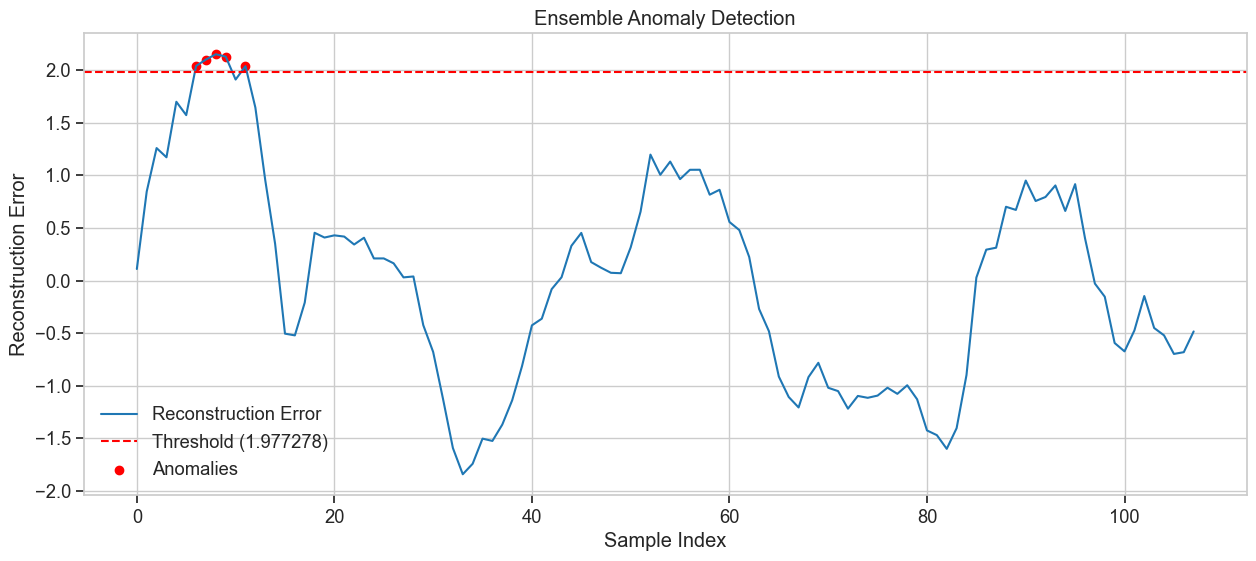

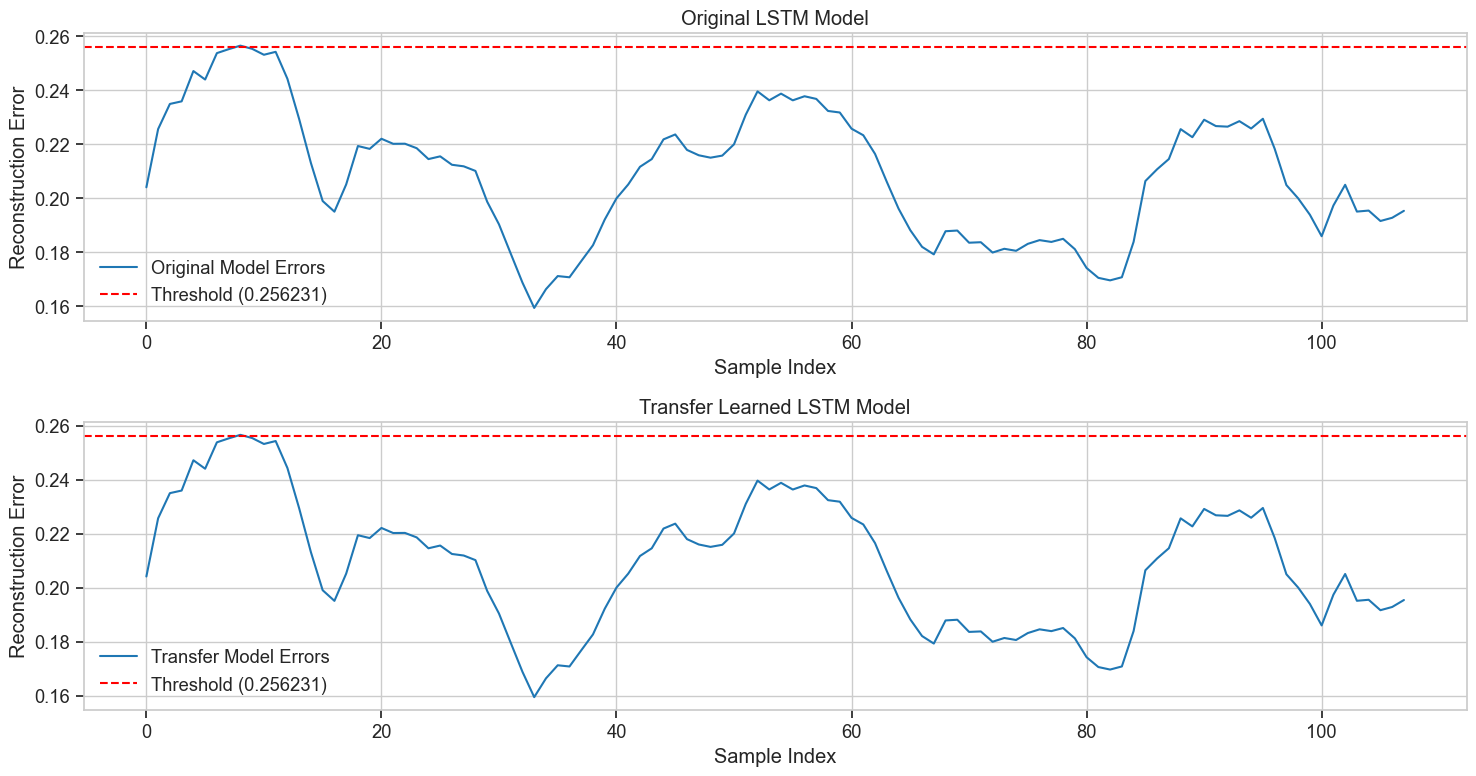

In [8]:

# Visualize anomalies
def plot_anomalies(errors, threshold, anomalies, title):
    plt.figure(figsize=(15, 6))
    
    plt.plot(errors, label='Reconstruction Error')
    plt.axhline(y=threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.6f})')
    
    # Mark anomalies
    anomaly_indices = np.where(anomalies)[0]
    plt.scatter(anomaly_indices, errors[anomaly_indices], color='red', label='Anomalies')
    
    plt.title(title)
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    
    return plt.gcf()

# Plot ensemble anomalies
plot_anomalies(ensemble_errors, ensemble_threshold, ensemble_anomalies, 'Ensemble Anomaly Detection')
plt.savefig('transfer_learning_anomalies.png', dpi=300)
plt.show()

# Compare original model vs transfer learned model
def compare_models(original_model, transfer_model, test_loader, device, title):
    """Compare performance of original vs transfer learned model."""
    original_errors, _, _ = get_reconstruction_errors(original_model, test_loader, device)
    transfer_errors, _, _ = get_reconstruction_errors(transfer_model, test_loader, device)
    
    original_threshold = np.mean(original_errors) + 2.0 * np.std(original_errors)
    transfer_threshold = np.mean(transfer_errors) + 2.0 * np.std(transfer_errors)
    
    plt.figure(figsize=(15, 8))
    
    plt.subplot(2, 1, 1)
    plt.plot(original_errors, label='Original Model Errors')
    plt.axhline(y=original_threshold, color='r', linestyle='--', label=f'Threshold ({original_threshold:.6f})')
    plt.title(f'Original {title} Model')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    
    plt.subplot(2, 1, 2)
    plt.plot(transfer_errors, label='Transfer Model Errors')
    plt.axhline(y=transfer_threshold, color='r', linestyle='--', label=f'Threshold ({transfer_threshold:.6f})')
    plt.title(f'Transfer Learned {title} Model')
    plt.xlabel('Sample Index')
    plt.ylabel('Reconstruction Error')
    plt.legend()
    plt.grid(True)
    
    plt.tight_layout()
    return plt.gcf()

# Compare LSTM original vs transfer learned
compare_models(pretrained_models["lstm"], fine_tuned_lstm, new_data["loaders"]["test"], device, "LSTM")
plt.savefig('lstm_transfer_comparison.png', dpi=300)
plt.show()


### 8. Model Saving

In [9]:

# Save transfer learned models
def save_transfer_models(models_dict, metadata_dict, base_path="models/transfer/"):
    """Save transfer learned models."""
    import os
    import json
    
    os.makedirs(base_path, exist_ok=True)
    
    for name, model in models_dict.items():
        model_path = os.path.join(base_path, f"{name}_model.pt")
        torch.save(model.state_dict(), model_path)
        logger.info(f"Modelo transfer learning {name} guardado en {model_path}")
    
    # Save ensemble weights
    weights_dict = {
        "lstm": float(ensemble.weights[0]),
        "gru": float(ensemble.weights[1]),
        "transformer": float(ensemble.weights[2])
    }
    
    with open(os.path.join(base_path, "ensemble_weights.json"), "w") as f:
        json.dump(weights_dict, f)
    
    # Save thresholds
    thresholds_dict = {
        "lstm": float(thresholds["lstm"]),
        "gru": float(thresholds["gru"]),
        "transformer": float(thresholds["transformer"]),
        "ensemble": float(ensemble_threshold)
    }
    
    with open(os.path.join(base_path, "thresholds.json"), "w") as f:
        json.dump(thresholds_dict, f)
    
    # Save metadata - usando el metadata pasado como parámetro
    transfer_metadata = {
        "sequence_length": metadata_dict.get("sequence_length", 150),
        "embedding_dim": metadata_dict.get("embedding_dim", 64),
        "source_dataset": "machine_temperature_system_failure.csv",
        "target_dataset": new_filepath
    }
    
    with open(os.path.join(base_path, "transfer_metadata.json"), "w") as f:
        json.dump(transfer_metadata, f)
    
    logger.info(f"Transfer learning models saved to {base_path}")

# Save transfer learned models
save_transfer_models(
    {
        "lstm": fine_tuned_lstm,
        "gru": fine_tuned_gru,
        "transformer": fine_tuned_transformer
    },
    metadata_dict=metadata,  # Pasar metadata como parámetro
    base_path="models/transfer/"
)


2025-05-23 21:40:58,796 - INFO - Modelo transfer learning lstm guardado en models/transfer/lstm_model.pt
2025-05-23 21:40:58,799 - INFO - Modelo transfer learning gru guardado en models/transfer/gru_model.pt
2025-05-23 21:40:58,804 - INFO - Modelo transfer learning transformer guardado en models/transfer/transformer_model.pt
2025-05-23 21:40:58,809 - INFO - Transfer learning models saved to models/transfer/


### 9. Model Loading

In [10]:

# Function to load transfer learned models
def load_transfer_models(base_path="models/transfer/"):
    import os
    import json
    
    # Load metadata
    with open(os.path.join(base_path, "transfer_metadata.json"), "r") as f:
        metadata = json.load(f)
    
    seq_len = metadata["sequence_length"]
    embedding_dim = metadata["embedding_dim"]
    
    # Initialize models
    lstm_model = LSTMAutoencoder(seq_len=seq_len, n_features=1, embedding_dim=embedding_dim)
    gru_model = GRUAutoencoder(seq_len=seq_len, n_features=1, embedding_dim=embedding_dim)
    transformer_model = TransformerEncoder(seq_len=seq_len, n_features=1, d_model=embedding_dim)
    
    # Load weights
    lstm_model.load_state_dict(torch.load(os.path.join(base_path, "lstm_model.pt")))
    gru_model.load_state_dict(torch.load(os.path.join(base_path, "gru_model.pt")))
    transformer_model.load_state_dict(torch.load(os.path.join(base_path, "transformer_model.pt")))
    
    # Load ensemble weights
    with open(os.path.join(base_path, "ensemble_weights.json"), "r") as f:
        weights_dict = json.load(f)
    
    weights = [weights_dict["lstm"], weights_dict["gru"], weights_dict["transformer"]]
    
    # Create ensemble model
    ensemble_model = EnsembleModel(
        models=[lstm_model, gru_model, transformer_model],
        names=["LSTM", "GRU", "Transformer"],
        weights=weights
    )
    
    # Load thresholds
    with open(os.path.join(base_path, "thresholds.json"), "r") as f:
        thresholds = json.load(f)
    
    logger.info(f"Transfer learning models loaded from {base_path}")
    
    return {
        "models": {
            "lstm": lstm_model,
            "gru": gru_model,
            "transformer": transformer_model,
            "ensemble": ensemble_model
        },
        "thresholds": thresholds,
        "metadata": metadata
    }